# FOV model
## renew on 2024-4-14

April Fool's Day Celebration Codes

## Setup

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc as pm
import pytensor.tensor as pt
import xarray as xr
import random
az.style.use("arviz-grayscale")

### Load data

Allfishtrial = pd.read_csv('tips.csv')
Allfishtrial.tail()

BRWR_fishid = pd.Categorical(Allfishtrial['fish_id'],
                     categories=['fish3', 'fish7', 'fish9', 'fish10']).codes
BRWR_sessiontype = pd.Categorical(Allfishtrial['session_type'],
                     categories=['Baseliine', 'Rotation', 'Washout', 'ReRotation']).codes


groups_fishid = len(np.unique(BRWR_fishid))


Priors calculation， should get these from raw data

In [2]:
first_day_value = 1
first_trial_value = 1

In [6]:
def gamma_shra_from_modesd(m, s):
    v = s**2
    ra = (m + np.sqrt(m**2 + 4*v)) / (2*v)
    sh = 1+m*ra
    return sh,ra

In [35]:
# fish_list = [4, 6, 7, 8, 10]
# stage_list = ['baseline', 'rotation', 'washout', 'savings', 'washout 2']
# days = {'baseline': 27, 'rotation': 16, 'washout': 10, 'savings': 16, 'washout 2': 10}

# # Initialize an empty list to store the data
# data = []

# stage_Amu = [-1, 5, -1, 5, -1]
# stage_Asd = [5, 5, 5, 5, 5]
# stage_tau = [100,100,100,100,100]
# stage_mu_inf = [0,0,0,0,0.2]


# # Generate data for each fish, epoch, day, and trial
# for f in fish_list:
#     for stage in stage_list:
#         Amu = np.random.normal(loc=stage_Amu[stage], scale=stage_Asd[stage])
#         tau = stage_tau[stage]
#         mu_inf = stage_mu_inf[stage]

#         for day in range(first_day_value, days[stage] + first_day_value):
#             num_trials = np.random.randint(4, 8)  # Randomly choose number of trials per day
#             day_mu = Amu*np.exp(-day/tau) + mu_inf

#             for trial in range(first_trial_value, num_trials + first_trial_value):
#                 yds = np.random.normal(loc=day_mu, scale=30)  # Generate random yds
#                 data.append([f, stage, day, trial, yds])

# # Create a pandas DataFrame
# df = pd.DataFrame(data, columns=['fish', 'stage', 'day', 'trial', 'yds'])

# num_data = df.shape[0]

In [36]:
# fish_list = [3, 7, 9, 10]
# stage_list = ['baseline', 'rotation', 'washout', 'savings', 'washout 2']
# days = {'baseline': 20, 'rotation': 15, 'washout': 10, 'savings': 15, 'washout 2': 10}

# # Initialize an empty list to store the data
# data = []

# # Define parameters for each stage
# stage_params = {
#     'baseline': {'Amu': -1, 'Asd': 3, 'tau': 1, 'mu_inf': 0},
#     'rotation': {'Amu': 5, 'Asd': 3, 'tau': 1, 'mu_inf': 0},
#     'washout': {'Amu': -1, 'Asd': 3, 'tau': 1, 'mu_inf': 0},
#     'savings': {'Amu': 5, 'Asd': 3, 'tau': 1, 'mu_inf': 0},
#     'washout 2': {'Amu': -1, 'Asd': 3, 'tau': 1, 'mu_inf': 0}
# }

# # Generate data for each fish, epoch, day, and trial
# for f in fish_list:
#     for stage in stage_list:
#         Amu = stage_params[stage]['Amu']
#         Asd = stage_params[stage]['Asd']
#         tau = stage_params[stage]['tau']
#         mu_inf = stage_params[stage]['mu_inf']

#         for day in range(1, days[stage] + 1):
#             num_trials = 6 # Randomly choose number of trials per day
#             day_mu = Amu * np.exp(-day / tau) + mu_inf

#             for trial in range(1, num_trials + 1):
#                 yds = np.random.normal(loc=day_mu, scale=30)  # Generate random yds
#                 data.append([f, stage, day, trial, yds])

# # Create a pandas DataFrame
# df = pd.DataFrame(data, columns=['fish', 'stage', 'day', 'trial', 'yds'])

# num_data = df.shape[0]
# print("Number of data points:", num_data)


Number of data points: 1680


In [21]:
stage_list = ['baseline', 'rotation', 'washout', 'savings', 'washout 2']

sim = {
#------------------------------------------------------------------------------------------
#    the parameter of μ_μd
    # The amount of learning across fish (for each stage)   For the normal distribution
    "μ_Aμμ": [-1, 5, -1, 5, -1],
    "σ_Aμμ": [5, 5, 5, 5, 5],
 
    # Time constant of learning across fish (for each stage)    For the the gamma distrition 
    "m_τμμ": [4, 4, 4, 4, 4],
    "σ_τμμ": [1.5, 1.5, 1.5, 1.5, 1.5],

    # End point of learning across fish (for each stage)    For the normal ditribution
    "μ_μμ_inf": [0, 0, 0, 0, 0],
    "σ_μμ_inf": [1, 1, 1, 1, 1],

#------------------------------------------------------------------------------------------
#   the parameter of σ_μd
    # Change in std of days around mean value across fish (for each stage) for the half-normal distribution
    "σ_Aσμ": [1, 1, 1, 1, 1],
     
    # Time std of learning across fish (for each stage)    For the the gamma distrition 
    "m_τσμ": [4, 4, 4, 4, 4],
    "σ_τσμ": [1.5, 1.5, 1.5, 1.5, 1.5],

    # Final std of days around mean value across fish (for each stage) for the half-normal distribution
    "σ_σμ_inf": [0.5, 0.5, 0.5, 0.5, 0.5],

#-------------------------------------------------------------------------------------------
#   the parameter of m_σd
    
    # Mode of change in std of trials around day across fish (for each stage) For the the gamma distrition 
    "m_Amσ": [20, 10, 10, 10, 5],
    "σ_Amσ": [10, 10, 10, 10, 10],

    # Time constant of variance reduction across fish (for each stage) For the the gamma distrition 
    "m_τμσ": [3, 3, 3, 3, 3],
    "σ_τμσ": [1.5, 1.5, 1.5, 1.5, 1.5],
    
    # Mode of final std of trials around day across fish (for each stage) For the the gamma distrition 
    "m_mσ_inf": [5, 5, 5, 5, 5],
    "σ_mσ_inf": [3, 3, 3, 3, 3],
#-----------------------------------------------------------------------------------------------
#   the parameter of σ_σd
    # Std of final std of trials around day across fish (for each stage) for the half-normal distribution
    "σ_Aσσ": [1, 1, 1, 1, 1],


    # Time constant of variance reduction across fish (for each stage) For the the gamma distrition 
    "m_τσσ": [3, 3, 3, 3, 3],
    "σ_τσσ": [1.5, 1.5, 1.5, 1.5, 1.5],
    
    # Mode of final std of trials around day across fish (for each stage) for the half-normal distribution
    "σ_σσ_inf": [3, 3, 3, 3, 3],  





}

sim_df = pd.DataFrame(index=stage_list, columns=sim.keys())
for k,v in sim.items():
    sim_df[k] = v

In [12]:
sim_df

,μ_Aμμ,σ_Aμμ,mode_τμ,σ_τμ,μ_μμ_inf,σ_μμ_inf,m_Aσμ,σ_Aσμ,m_σμ_inf,σ_σμ_inf,m_Amσ,mode_τσ,σ_τσ,μ_mσ_inf,σ_mσ_inf,m_Aσσ,σ_Aσσ
baseline,-1,5,4,1.5,0,1,3,1,0.5,0.5,10,3,1.5,5,3,2,1
rotation,5,5,4,1.5,0,1,3,1,0.5,0.5,10,3,1.5,5,3,2,1
washout,-1,5,4,1.5,0,1,3,1,0.5,0.5,10,3,1.5,5,3,2,1
savings,5,5,4,1.5,0,1,3,1,0.5,0.5,10,3,1.5,5,3,2,1
washout 2,-1,5,4,1.5,0,1,3,1,0.5,0.5,10,3,1.5,5,3,2,1


In [26]:
fish_list = [3, 7, 9, 10]
days = {'baseline': 25, 'rotation': 15, 'washout': 10, 'savings': 15, 'washout 2': 10}

# Initialize an empty list to store the data
data = []

# Generate data for each fish, epoch, day, and trial
for f in fish_list:
    for stage in stage_list:
        sim_s = sim_df.loc[stage]
        
        # Parameters for mean of days
        A_mumu = np.random.normal(loc=sim_s["μ_Aμμ"], scale=sim_s["σ_Aμμ"])
        tau_sh, tau_ra = gamma_shra_from_modesd(sim_s["m_τμμ"], sim_s["σ_τμμ"])
        tau_mumu = np.random.gamma(shape=tau_sh, scale=1/tau_ra)
        mumu_inf = np.random.normal(loc=sim_s["μ_μμ_inf"], scale=sim_s["σ_μμ_inf"])        
        
        # Parameters for std of days
        A_sdmu = np.abs(np.random.normal(loc=0, scale=sim_s["σ_Aσμ"]))
        tau_sh, tau_ra = gamma_shra_from_modesd(sim_s["m_τσμ"], sim_s["σ_τσμ"])
        tau_sdmu = np.random.gamma(shape=tau_sh, scale=1/tau_ra)
        σ_sdmu_inf = np.abs(np.random.normal(loc=0, scale=sim_s["σ_σμ_inf"]))

        
        # Parameters for std of trials within day
        # m_σd
        tau_sh, tau_ra = gamma_shra_from_modesd(sim_s["m_Amσ"], sim_s["σ_Amσ"])
        A_musd = np.random.gamma(shape=tau_sh, scale=1/tau_ra)
        tau_sh, tau_ra = gamma_shra_from_modesd(sim_s["m_τμσ"], sim_s["σ_τμσ"])
        tau_musd = np.random.gamma(shape=tau_sh, scale=1/tau_ra)
        tau_sh, tau_ra = gamma_shra_from_modesd(sim_s["m_mσ_inf"], sim_s["σ_mσ_inf"])
        mu_sd_inf = np.random.gamma(shape=tau_sh, scale=1/tau_ra) 


        #σ_σd
        A_sdsd = np.abs(np.random.normal(loc=0, scale=sim_s["σ_Aσσ"])) 
        tau_sh, tau_ra = gamma_shra_from_modesd(sim_s["m_τσσ"], sim_s["σ_τσσ"])     
        tau_sdsd = np.random.gamma(shape=tau_sh, scale=1/tau_ra)
        σ_sdsd = np.abs(np.random.normal(loc=0, scale=sim_s["σ_σσ_inf"]))         
        





        for day in range(first_day_value, days[stage] + first_day_value):
            num_trials = 6  # Randomly choose number of trials per day
            day_mu_mu = A_mumu*np.exp(-day/tau_mumu) + mumu_inf
            day_mu_sd = A_sdmu*np.exp(-day/tau_sdmu) + σ_sdmu_inf
            day_mu = np.random.normal(loc=day_mu_mu, scale=day_mu_sd)

            day_sd_mu = A_musd*np.exp(-day/tau_musd) + mu_sd_inf
            day_sd_sd = A_sdsd*np.exp(-day/tau_sdsd) + σ_sdsd

            tau_sh, tau_ra = gamma_shra_from_modesd(day_sd_mu, day_sd_sd)  
            day_sd = np.random.gamma(shape=tau_sh, scale=1/tau_ra)
                 


            for trial in range(first_trial_value, num_trials + first_trial_value):
                yds = np.random.normal(loc=day_mu, scale=day_sd)  # Generate random yds
                data.append([f, stage, day, trial, yds])

# Create a pandas DataFrame
df = pd.DataFrame(data, columns=['fish', 'stage', 'day', 'trial', 'yds'])

num_data = df.shape[0]

In [28]:
df

,fish,stage,day,trial,yds
0,3,baseline,1,1,13.500504
1,3,baseline,1,2,3.828303
2,3,baseline,1,3,14.192367
3,3,baseline,1,4,18.665268
4,3,baseline,1,5,5.753556
...,...,...,...,...,...
1795,10,washout 2,10,2,-8.062393
1796,10,washout 2,10,3,-10.820950
1797,10,washout 2,10,4,-2.801342
1798,10,washout 2,10,5,-0.245477


## Define model

### Priors

#### μ_μ hyper priors

In [40]:
# Priors for Aμμ
df_avg = df.groupby(['fish', 'stage', 'day']).agg({'yds': 'mean'}).reset_index()

mean_first_day = df_avg[df_avg['day'] == first_day_value]
max_day_indices = df_avg.groupby(['fish', 'stage'])['day'].idxmax()
mean_last_day = df_avg.loc[max_day_indices]

merged_data = pd.merge(mean_first_day, mean_last_day, on=['fish', 'stage'], suffixes=('_first', '_last'))
merged_data['difference'] = merged_data['yds_first'] - merged_data['yds_last']

μ_Aμμ = merged_data['difference'].mean()
σ_Aμμ = merged_data['difference'].std()

# Priors for τ_μμ
merged_data['halfway_yds'] = (merged_data['yds_first'] + merged_data['yds_last']) / 2
df_avg = pd.merge(df_avg, merged_data[['fish', 'stage', 'halfway_yds']], on=['fish', 'stage'])

df_avg_below_halfway = df_avg[df_avg['yds'] < df_avg['halfway_yds']].groupby(['fish', 'stage']).agg({'day': 'first'}).reset_index()

mode_τμ = df_avg_below_halfway['day'].mean()
σ_τμ = df_avg_below_halfway['day'].std()

sh_τμ,ra_τμ = gamma_shra_from_modesd(mode_τμ, σ_τμ)

# Priors for μ_μ∞
μ_μμ_inf = mean_last_day['yds'].mean()
σ_μμ_inf = mean_last_day['yds'].std()


In [41]:
print(f'{μ_Aμμ=}')
print(f'{σ_Aμμ=}')

print(f'{mode_τμ=}')
print(f'{σ_τμ=}')

print(f'{μ_μμ_inf=}')
print(f'{σ_μμ_inf=}')


μ_Aμμ=0.9265539048379455
σ_Aμμ=19.425435294744098
mode_τμ=1.75
σ_τμ=0.8506963092234007
μ_μμ_inf=-0.831888589996144
σ_μμ_inf=11.957843969228518


#### σ_μ hyper priors

In [42]:
# Priors for Aσμ
σ_Aσμ = merged_data['difference'].std()

# Priors for σ_μ∞
σ_σμ_inf = mean_last_day['yds'].std()


In [43]:
print(f'{σ_Aσμ=}')

# print(f'{μ_τμ=}')
print(f'{σ_τμ=}')

print(f'{σ_σμ_inf=}')

σ_Aσμ=19.425435294744098
σ_τμ=0.8506963092234007
σ_σμ_inf=11.957843969228518


#### μ_σ hyper priors

In [44]:
# Priors for Aμσ
df_std = df.groupby(['fish', 'stage', 'day']).agg({'yds': 'std'}).reset_index()
df_std.rename(columns={'yds': 'std_yds'}, inplace=True)

std_first_day = df_std[df_std['day'] == first_day_value]
last_day_indices = df_std.groupby(['fish', 'stage'])['day'].idxmax()
std_last_day = df_std.loc[last_day_indices]

merged_std = pd.merge(std_first_day, std_last_day, on=['fish', 'stage'], suffixes=('_first', '_last'))
merged_std['std_diff'] = merged_std['std_yds_last'] - merged_std['std_yds_first']


μ_Aμσ = merged_std['std_diff'].mean()
σ_Aμσ = merged_std['std_diff'].std()


# Priors for τ_μσ
merged_std['halfway_std'] = (merged_std['std_yds_first'] + merged_std['std_yds_last']) / 2
df_std = pd.merge(df_std, merged_std[['fish', 'stage', 'halfway_std']], on=['fish', 'stage'])
std_less_than_halfway = df_std[df_std['std_yds'] < df_std['halfway_std']].groupby(['fish', 'stage']).agg({'day': 'min'}).reset_index()

mode_τσ = std_less_than_halfway['day'].mean()
σ_τσ = std_less_than_halfway['day'].std()

sh_τσ,ra_τσ = gamma_shra_from_modesd(mode_τσ, σ_τσ)

# Priors for μ_σ∞
μ_μσ_inf = std_last_day['std_yds'].mean()
σ_μσ_inf = std_last_day['std_yds'].std()

In [45]:
print(f'{μ_Aμσ=}')
print(f'{σ_Aμσ=}')

print(f'{mode_τσ=}')
print(f'{σ_τσ=}')

print(f'{μ_μσ_inf=}')
print(f'{σ_μσ_inf=}')

μ_Aμσ=-1.7206541415273116
σ_Aμσ=9.854612088991562
mode_τσ=2.6
σ_τσ=2.280350850198276
μ_μσ_inf=28.211124074826547
σ_μσ_inf=11.028520585616253


#### σ_σ hyper priors

In [46]:
# Priors for Aσσ
σ_Aσσ = merged_std['std_diff'].std()

# Priors for σ_μ∞
σ_σσ_inf = std_last_day['std_yds'].std()

In [47]:
print(f'{σ_Aσσ=}')

print(f'{σ_σσ_inf=}')

σ_Aσσ=9.854612088991562
σ_σσ_inf=11.028520585616253


#### Prior for student's t distribution degrees of freedom

In [48]:
μ_ν = 10

### PyMC model code

#### Make codings for fish and stage

In [49]:
fish_index_map = {fish: index for index, fish in enumerate(fish_list)}
stage_index_map = {stage: index for index, stage in enumerate(stage_list)}

# Replace fish numbers with their corresponding indices
df['fish_index'] = df['fish'].map(fish_index_map)
df['stage_index'] = df['stage'].map(stage_index_map)
df['day_index'] = df['day'] - first_day_value

#### Model code

In [50]:
coords = {
    "fish": fish_list,
    "stages": stage_list,
    "data": np.arange(num_data),
}

with pm.Model(coords=coords) as m_yds:
    ### Constants
    fish_ = pm.ConstantData('fish_', df['fish_index'], dims='data')
    stage_ = pm.ConstantData('stage_', df['stage_index'], dims='data')
    day_ = pm.ConstantData('day_', df['day_index'], dims='data')

    ### level 4: Priors for μ_μ, μ_σ, σ_μ, σ_σ
    A_μμ = pm.Normal('A_μμ', mu=μ_Aμμ, sigma=σ_Aμμ, dims=('fish', 'stages'))
    τ_μ = pm.Gamma('τ_μ', alpha=sh_τμ, beta=ra_τμ, dims=('fish', 'stages'))
    μ_μ_inf = pm.Normal('μ_μ_inf', mu=μ_μμ_inf, sigma=σ_μμ_inf, dims=('fish', 'stages'))

    A_σμ = pm.HalfNormal('A_σμ', sigma=σ_Aσμ, dims=('fish', 'stages'))
    σ_μ_inf = pm.HalfNormal('σ_μ_inf', sigma=σ_σμ_inf, dims=('fish', 'stages'))

    A_μσ = pm.Normal('A_μσ', mu=μ_Aμμ, sigma=σ_Aμμ, dims=('fish', 'stages'))
    τ_σ = pm.Gamma('τ_σ', alpha=sh_τσ, beta=ra_τσ, dims=('fish', 'stages'))
    μ_σ_inf = pm.Normal('μ_σ_inf', mu=μ_μσ_inf, sigma=σ_μσ_inf, dims=('fish', 'stages'))

    A_σσ = pm.HalfNormal('A_σσ', sigma=σ_Aμμ, dims=('fish', 'stages'))
    σ_σ_inf = pm.HalfNormal('σ_σ_inf', sigma=σ_σσ_inf, dims=('fish', 'stages'))

    ### level 3: Regression equations for μ and σ
    μ_μ = pm.Deterministic('μ_μ', A_μμ[fish_,stage_]*pm.math.exp(-day_ / τ_μ[fish_,stage_]) + μ_μ_inf[fish_,stage_], dims='data' )
    σ_μ = pm.Deterministic('σ_μ', A_σμ[fish_,stage_]*pm.math.exp(-day_ / τ_μ[fish_,stage_]) + σ_μ_inf[fish_,stage_], dims='data')
    mode_σ = pm.Deterministic('μ_σ', A_μσ[fish_,stage_]*pm.math.exp(-day_ / τ_σ[fish_,stage_]) + μ_σ_inf[fish_,stage_], dims='data')
    σ_σ = pm.Deterministic('σ_σ', A_σσ[fish_,stage_]*pm.math.exp(-day_ / τ_σ[fish_,stage_]) + σ_σ_inf[fish_,stage_], dims='data')
    sh_σ,ra_σ = gamma_shra_from_modesd(mode_σ,σ_σ)

    ### level 2: Priors for the likelihood
    μ = pm.Normal('μ', mu=μ_μ, sigma=σ_μ, dims='data')    
    σ = pm.Gamma('σ', alpha=sh_σ, beta=ra_σ, dims='data')
    ν = pm.Exponential('ν', lam=1/μ_ν)
    
    ### data likelihood level 1
    y = pm.StudentT('y', mu=μ, sigma=σ, nu=ν, observed=df['yds'], dims='data')


## Sample prior predictive

In [51]:
id_yds = pm.sample_prior_predictive(samples=100, model=m_yds)

Sampling: [A_μμ, A_μσ, A_σμ, A_σσ, y, μ, μ_μ_inf, μ_σ_inf, ν, σ, σ_μ_inf, σ_σ_inf, τ_μ, τ_σ]


In [52]:
id_yds

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

prior predictive check for μ_μ

In [71]:
m_yds_draw

<xarray.DataArray 'draw' (draw: 100)> Size: 400B
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99])
Coordinates:
  * draw     (draw) int32 400B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99

In [53]:
prior = id_yds.prior

In [66]:
prior["μ_μ"].size

168000

In [93]:
prior["μ"].sel(data=slice(0, 119)).size


12000

In [68]:
prior["μ"].size

168000

In [57]:
id_yds.prior['chain'].size

1

In [58]:
m_yds_draw = id_yds.prior['draw']



C:\Users\86153\AppData\Local\Temp\ipykernel_17828\1499001669.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


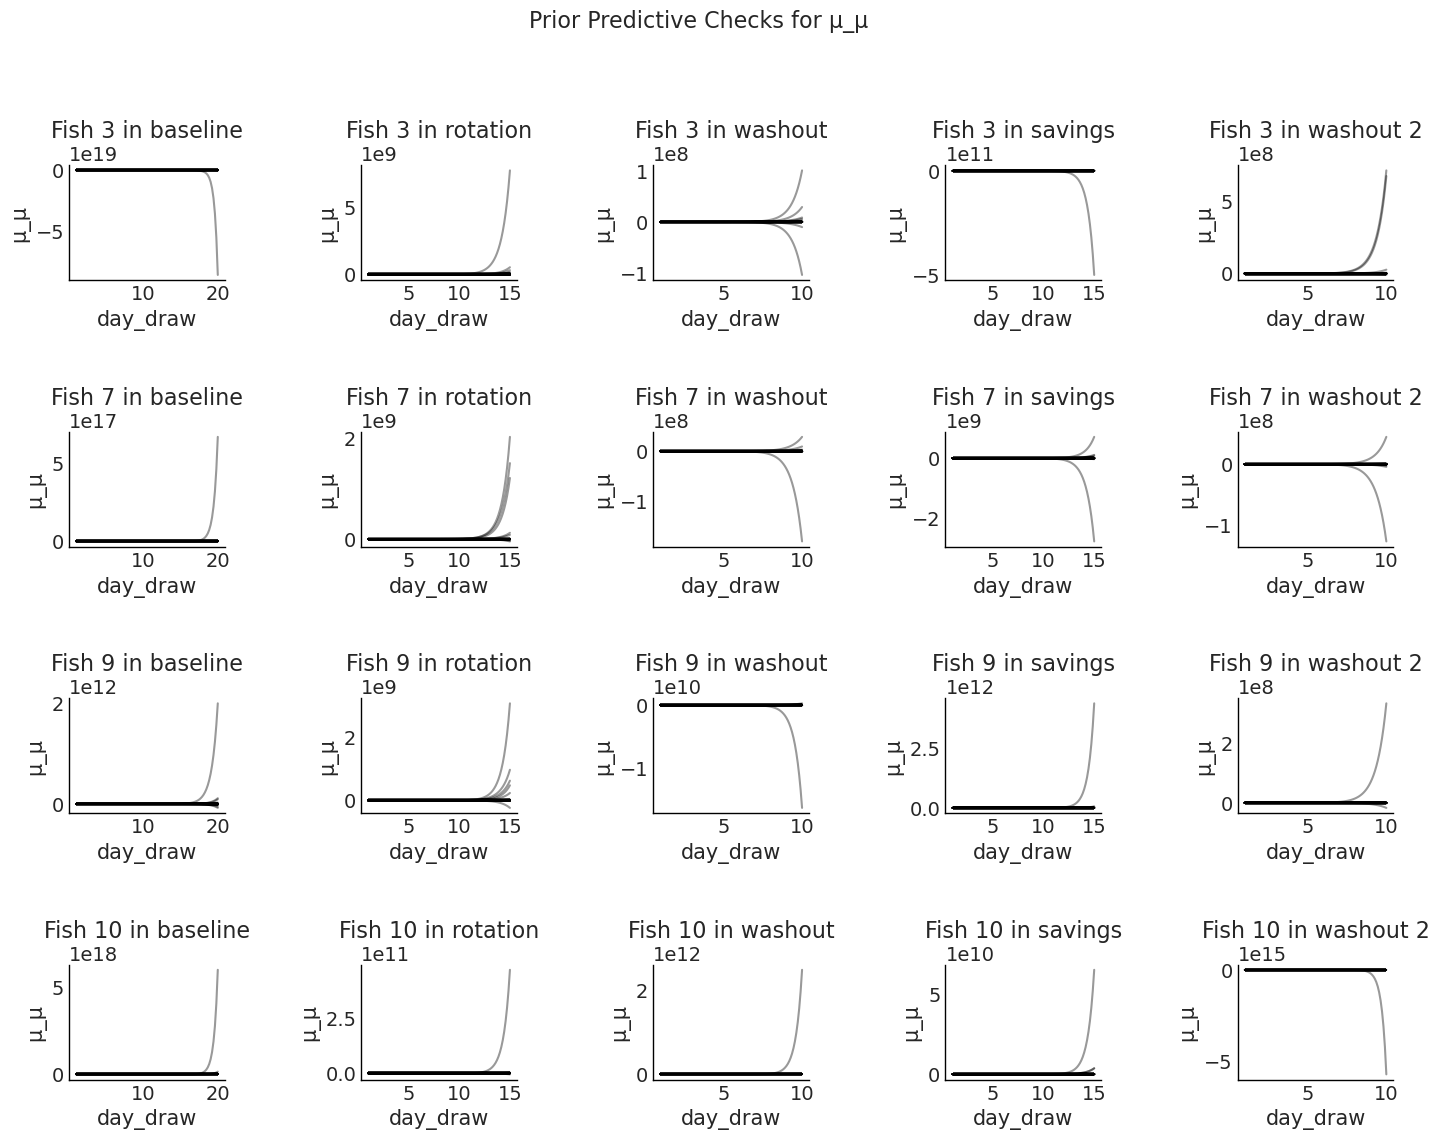

In [97]:

fig, axes = plt.subplots(len(fish_list), len(stage_list), figsize=(15, 12)) # Adjust the size as needed

for i, fish_id in enumerate(fish_list):
    for j, stage_id in enumerate(stage_list):
        A_μμ_fs = prior["A_μμ"].sel(fish=fish_id, stages=stage_id)
        μ_μ_inf_fs = prior["μ_μ_inf"].sel(fish=fish_id, stages=stage_id)
        τ_μ_fs = prior["τ_μ"].sel(fish=fish_id, stages=stage_id)
        if stage_id == 'baseline':
            day_range = 20
        elif stage_id == 'rotation' or stage_id == 'savings':
            day_range = 15
        else: 
            day_range = 10
        day_draw = xr.DataArray(np.linspace(1, day_range, 100))

        μ_μ = A_μμ_fs * np.exp(day_draw / τ_μ_fs) + μ_μ_inf_fs
        
        ax = axes[i, j] # Get the specific subplot
        ax.plot(day_draw, μ_μ.stack(sample=("chain", "draw")), c="k", alpha=0.4)
        ax.set_xlabel("day_draw")
        ax.set_ylabel("μ_μ")
        ax.set_title(f"Fish {fish_id} in {stage_id}")

fig.suptitle('Prior Predictive Checks for μ_μ ', fontsize=16)  # Add a main title here
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
plt.tight_layout(pad=4.0)
plt.show()

  

C:\Users\86153\AppData\Local\Temp\ipykernel_17828\3139674907.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


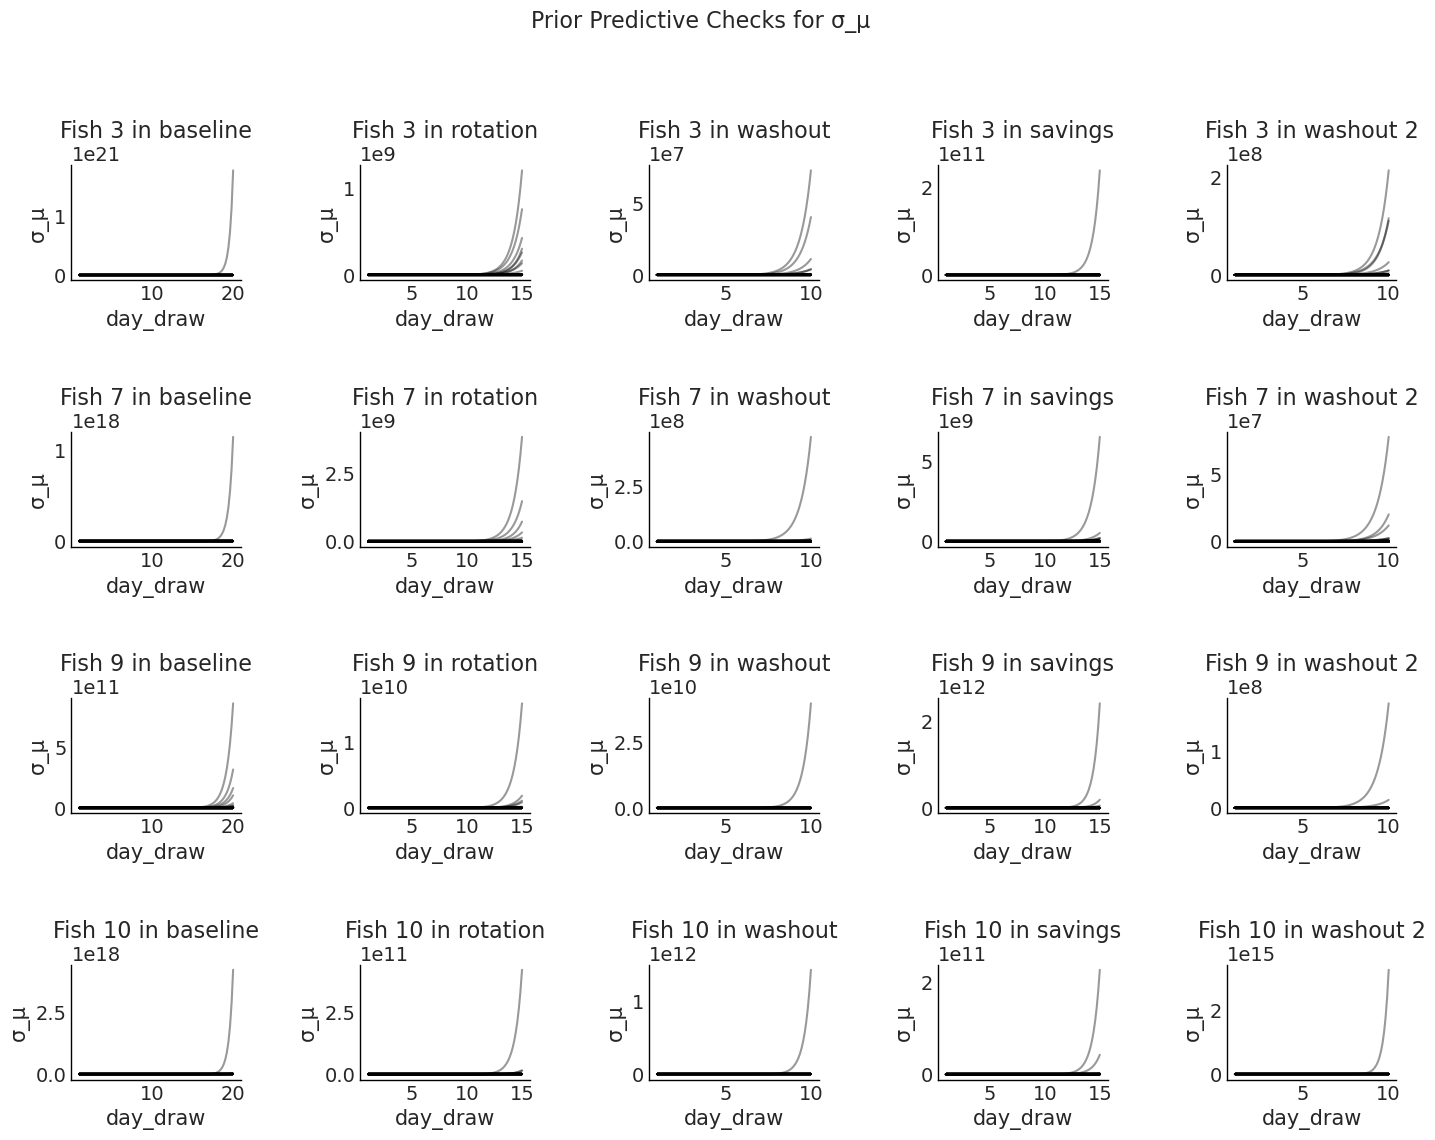

In [98]:

fig, axes = plt.subplots(len(fish_list), len(stage_list), figsize=(15, 12)) # Adjust the size as needed

for i, fish_id in enumerate(fish_list):
    for j, stage_id in enumerate(stage_list):
        A_σμ_fs = prior["A_σμ"].sel(fish=fish_id, stages=stage_id)
        σ_μ_inf_fs = prior["μ_μ_inf"].sel(fish=fish_id, stages=stage_id)
        τ_μ_fs = prior["τ_μ"].sel(fish=fish_id, stages=stage_id)
        if stage_id == 'baseline':
            day_range = 20
        elif stage_id == 'rotation' or stage_id == 'savings':
            day_range = 15
        else:  
            day_range = 10
        day_draw = xr.DataArray(np.linspace(1, day_range, 100))
        σ_μ = A_σμ_fs * np.exp(day_draw / τ_μ_fs) + σ_μ_inf_fs
        
        ax = axes[i, j] # Get the specific subplot
        ax.plot(day_draw , σ_μ.stack(sample=("chain", "draw")), c="k", alpha=0.4)
        ax.set_xlabel("day_draw")
        ax.set_ylabel("σ_μ")
        ax.set_title(f"Fish {fish_id} in {stage_id}")

fig.suptitle('Prior Predictive Checks for σ_μ ', fontsize=16)  # Add a main title here
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
plt.tight_layout(pad=4.0)
plt.show()

  

C:\Users\86153\AppData\Local\Temp\ipykernel_17828\566426822.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


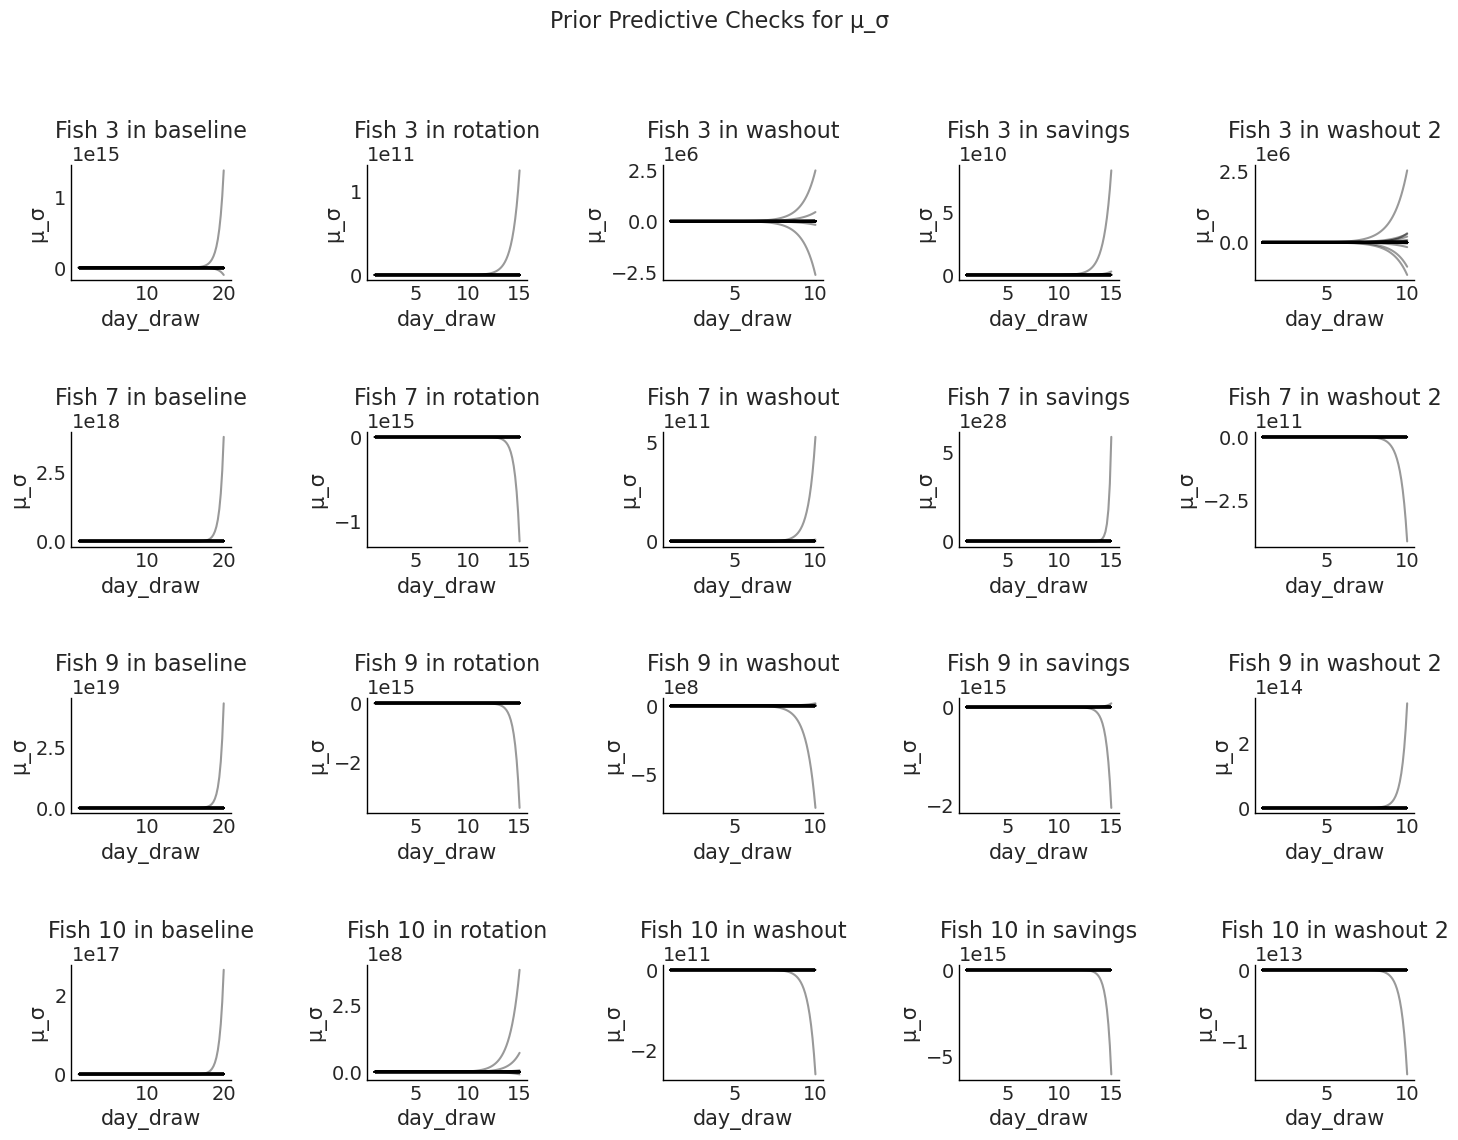

In [99]:

fig, axes = plt.subplots(len(fish_list), len(stage_list), figsize=(15, 12)) # Adjust the size as needed

for i, fish_id in enumerate(fish_list):
    for j, stage_id in enumerate(stage_list):
        A_μσ_fs = prior["A_μσ"].sel(fish=fish_id, stages=stage_id)
        μ_σ_inf_fs = prior["μ_μ_inf"].sel(fish=fish_id, stages=stage_id)
        τ_σ_fs = prior["τ_σ"].sel(fish=fish_id, stages=stage_id)

        if stage_id == 'baseline':
            day_range = 20
        elif stage_id == 'rotation' or stage_id == 'savings':
            day_range = 15
        else: 
            day_range = 10
        day_draw = xr.DataArray(np.linspace(1, day_range, 100))
        
        μ_σ = A_μσ_fs * np.exp(day_draw / τ_σ_fs) + μ_σ_inf_fs
        
        ax = axes[i, j] # Get the specific subplot
        ax.plot(day_draw, μ_σ.stack(sample=("chain", "draw")), c="k", alpha=0.4)
        ax.set_xlabel("day_draw")
        ax.set_ylabel("μ_σ")
        ax.set_title(f"Fish {fish_id} in {stage_id}")

fig.suptitle('Prior Predictive Checks for μ_σ ', fontsize=16)  # Add a main title here
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
plt.tight_layout(pad=4.0)
plt.show()

  

C:\Users\86153\AppData\Local\Temp\ipykernel_17828\635383226.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


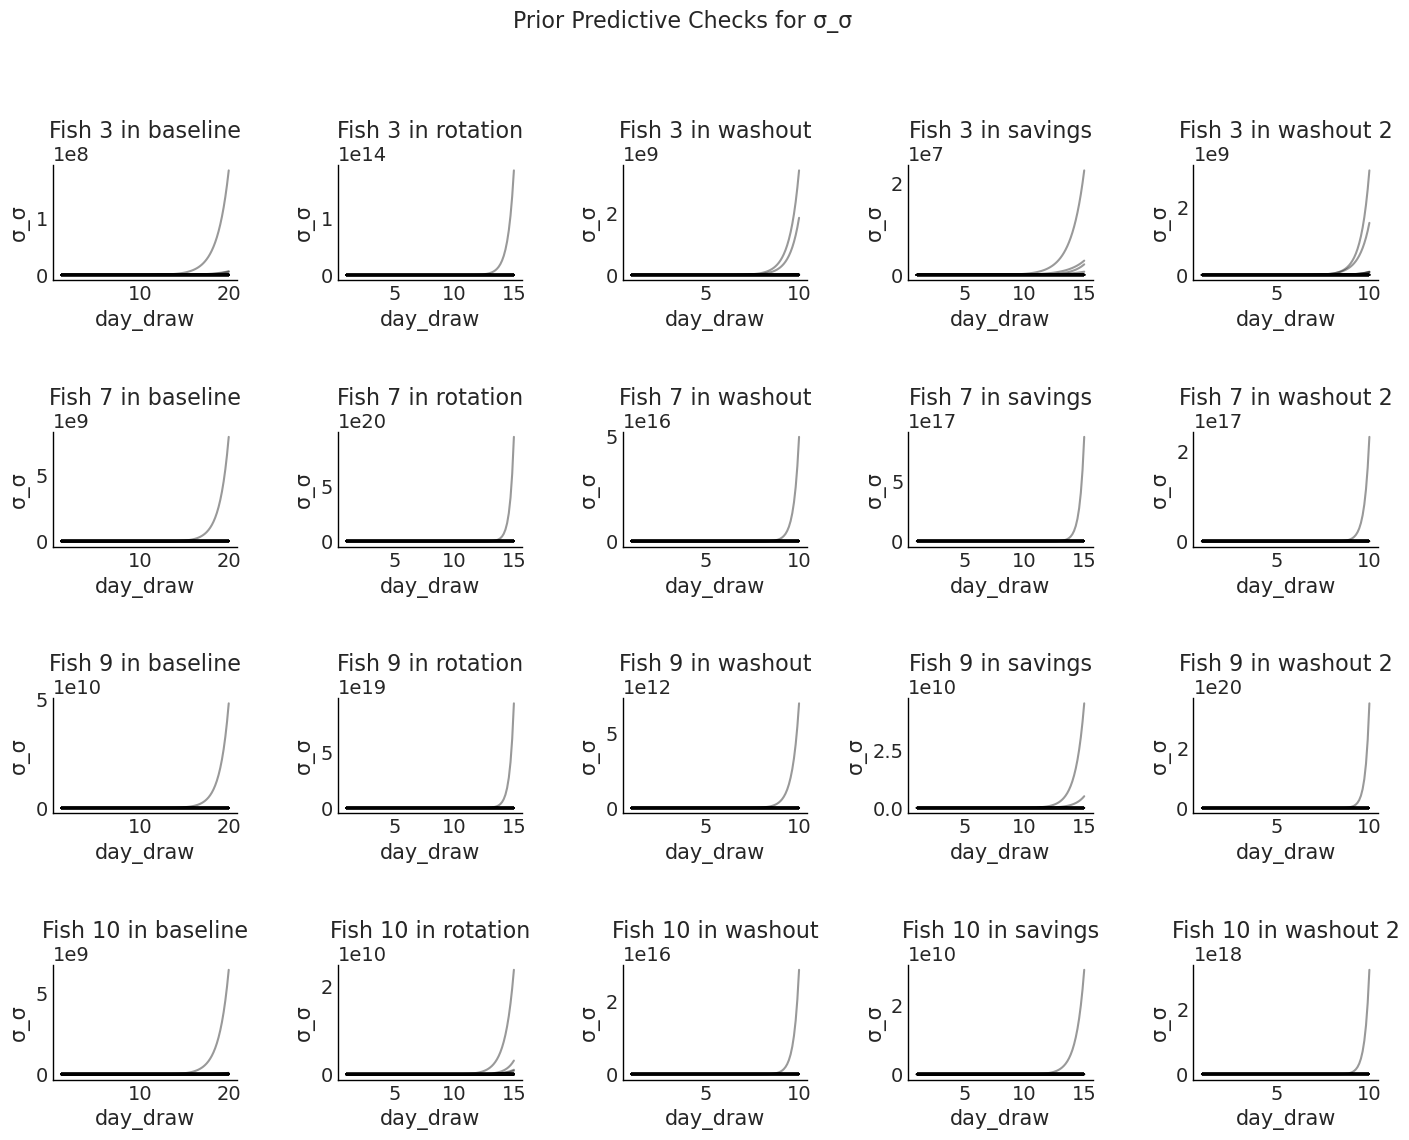

In [100]:

fig, axes = plt.subplots(len(fish_list), len(stage_list), figsize=(15, 12)) # Adjust the size as needed

for i, fish_id in enumerate(fish_list):
    for j, stage_id in enumerate(stage_list):
        A_σσ_fs = prior["A_σσ"].sel(fish=fish_id, stages=stage_id)
        σ_σ_inf_fs = prior["σ_σ_inf"].sel(fish=fish_id, stages=stage_id)
        τ_σ_fs = prior["τ_σ"].sel(fish=fish_id, stages=stage_id)
        σ_σ = A_σσ_fs * np.exp(day_draw / τ_σ_fs) + μ_σ_inf_fs

        if stage_id == 'baseline':
            day_range = 20
        elif stage_id == 'rotation' or stage_id == 'savings':
            day_range = 15
        else: 
            day_range = 10
        day_draw = xr.DataArray(np.linspace(1, day_range, 100))       
        ax = axes[i, j] # Get the specific subplot
        ax.plot(day_draw, σ_σ.stack(sample=("chain", "draw")), c="k", alpha=0.4)
        ax.set_xlabel("day_draw")
        ax.set_ylabel("σ_σ")
        ax.set_title(f"Fish {fish_id} in {stage_id}")

fig.suptitle('Prior Predictive Checks for σ_σ ', fontsize=16)  # Add a main title here
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
plt.tight_layout(pad=4.0)
plt.show()

  

C:\Users\86153\AppData\Local\Temp\ipykernel_17828\1106214750.py:43: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


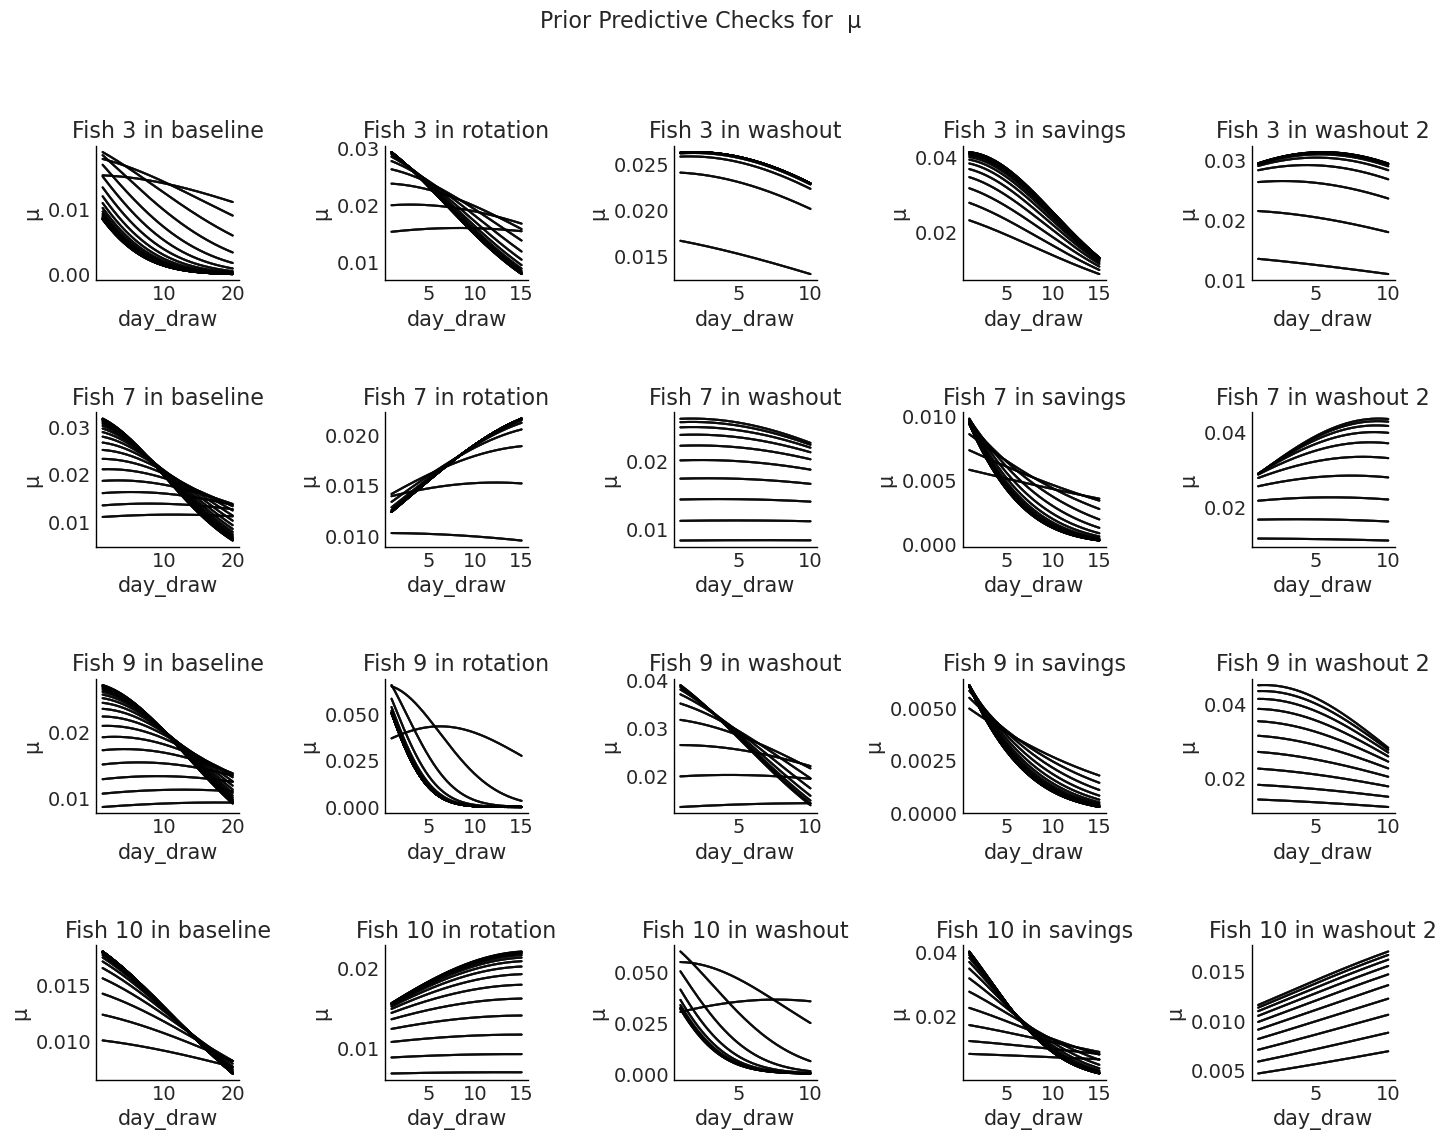

In [120]:

fig, axes = plt.subplots(len(fish_list), len(stage_list), figsize=(15, 12)) # Adjust the size as needed

for i, fish_id in enumerate(fish_list):

    for j, stage_id in enumerate(stage_list):
        if stage_id == 'baseline':
            day_range = 20
            data_id = data=slice(0+ i*420, 119+ i*420)
        elif stage_id == 'rotation':
            day_range = 15

            data_id = data=slice(120+ i*420, 209+ i*420) 
        elif  stage_id == 'savings':
            day_range = 15

            data_id = data=slice(270+ i*420,359+ i*420) 
        elif  stage_id == 'washout':
            day_range = 10

            data_id = data=slice(210+ i*420, 269+ i*420) 
        else: 
            day_range = 10

            data_id = data=slice(360+ i*420, 419+ i*420) 
        sample_day = day_range*6
        day_draw = xr.DataArray(np.linspace(1, day_range, 100*6*day_range)) 
        
        μ_μ_fs = prior["μ_μ"].sel(data = data_id)
        σ_μ_fs = prior["σ_μ"].sel(data = data_id)
        
        μ_fs = (1 / (σ_μ_fs  * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (((day_draw - μ_μ_fs)) / σ_μ_fs ) ** 2)
        

        ax = axes[i, j] # Get the specific subplot
        for k in range(sample_day):
            ax.plot(day_draw, μ_fs[0, 0, k, :], c="k", alpha=0.4)

        ax.set_xlabel("day_draw")
        ax.set_ylabel("μ")
        ax.set_title(f"Fish {fish_id} in {stage_id}")

fig.suptitle('Prior Predictive Checks for  μ ', fontsize=16)  # Add a main title here
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
plt.tight_layout(pad=4.0)
plt.show()

  

Try sample

In [ ]:
with m_yds:
    id_yds.extend(pm.sample(1000, tune=2000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

In [ ]:
az.plot_trace(id_yds)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001DFFFEF7560> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
%load_ext watermark
%watermark -v -iv -w